## Logistic Regression

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
np.set_printoptions(suppress=True)

### Idea

- In logistic regression, we want to constrain the output to values between 0 and 1. As such, we want to solve the following equation:
    $$\begin{aligned}
        y &= \frac{1}{1 + e^{-X\beta}}
    \end{aligned}$$

- This is exactly like in OLS, where we solve for $y = X\beta$, but here we scale the output by the sigmoid function to constrain it beween 0 and 1


In [3]:
def sigmoid(input_arr: np.array) -> np.array:
    return 1/(1 + np.exp(-input_arr))

sigmoid(np.array([-100, -50, -10, -1, 1, 10, 50, 100]))

array([0.        , 0.        , 0.0000454 , 0.26894142, 0.73105858,
       0.9999546 , 1.        , 1.        ])

### Solving for $\hat{\beta}$ in Logistic Regression

- In OLS, we know that given a design matrix $X$, we can find coefficients such that
$$\begin{aligned}
    \hat{\beta} &= (X^TX)^{-1} X^Ty \\
    \text{Var}(\hat{\beta}) &= \sigma^2 (X^TX)^{-1} \\
\end{aligned}$$

- In logistic regression, however, there is no closed form solution. Instead, iterative optimisation methods are needed to solve for $\hat{\beta}$

- We'll explore all 3 of the following iterative methods. 
    - Gradient Descent
    - Newton-Raphson Method
    - Iteratively Reweighted Least Squares (IRLS)

### Loss Function in Logistic Regression: Why negative logloss?

- "Optimisation" implies that there is a target we are optimising towards. That is; we want something to either be as small as possible, or as large as possible
    - For example, in OLS, we want to optimise (i.e. minimise) the Mean-Squared Error (MSE)

- In the case of Logistic Regression, what are we optimising? That is, how should we evaluate the algorithm such that we know that we are getting "more correct" as we change the weights?

- Some intuitive candidates:
    - Mean Squared Error (MSE): 
        - What's stopping us from using the same MSE metric? 
        - Even though the output is now constrained between 0 and 1, surely it still applies that we want the squared errors (either from 1 or 0) to be minimsed?

    - Accuracy:
        - It is also intuitive to think that we want to optimise for "accuracy". 
        - Since the sigmoid function produces values between 0 and 1, this is commonly interpreted as probabilities
        - Depending on our cutoff value (say 0.5), anything above the cutoff can be labelled a 1 and anything below a 0

#### Optimising using Mean Squared Error (MSE)

- Let's consider what happens when we use MSE in a logistic regression setting

In [4]:
def mse(preds, labels):
    return np.sum((preds-labels)**2)/len(preds)

In [5]:
labels = np.random.choice([0,1], 500)
preds = np.array([np.random.uniform(0.2,0.6) if x == 0 else np.random.uniform(0.4,0.8) for x in labels])
mse(preds, labels)

np.float64(0.18551242391656175)

- In lieu of a model, let's see what happens as our "model" gets better
    - To simulate it, we just take np.random.uniform and narrow the range of values for the bad and good case, keeping the same mean
    - That is, a better model will produce a "narrower" range of predicted values 

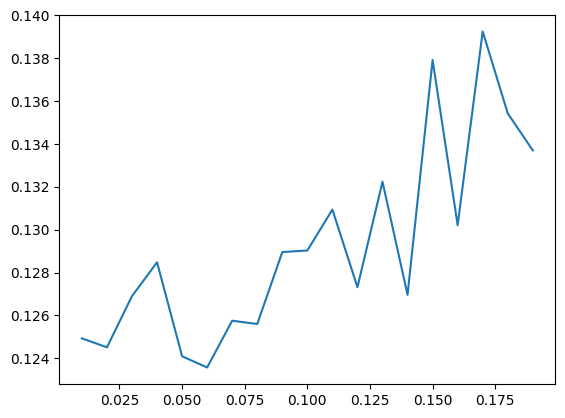

In [6]:
res = []
for i in np.arange(0.01,0.2,0.01):
    labels = np.random.choice([0,1], 500)
    preds = np.array([np.random.uniform(0.3-i,0.3+i) if x == 0 else np.random.uniform(0.6-i,0.6+i) for x in labels])
    res.append(mse(preds, labels))

plt.plot(np.arange(0.01,0.2,0.01), res)

- Even though the model clearly gets "better" as $i$ decreases, the MSE error doesn't actually show a smooth decrease! In fact, we see local spikes and troughs, which may cause us to become stuck in local optimal points 

- For example, imagine that we decreases $i$ from 0.4. Upon reaching 0.33, decreasing $i$ further leads us to a spike in MSE, which may lead us to conclude that we should stop our descent!

#### Optimising using Accuracy

- Trying to optimise using something like accuracy is even worse

- It is entirely possible that, with changes in your model, the accuracy does not change, giving you no way to update the model!

- Also, accuracy is not a continuous value, so changes in accuracy is a step function. This precludes optimisation methods like gradient descent

#### Logloss from First Principles

- So far, we've kind of touched on what makes a good loss function
    1. A good loss function should be continuously differentiable
        - So incremental changes to $\hat{\beta}$ can produce small changes in the loss function
    2. A good loss function should reflect gradations of "wrongness"
        - When dealing with loss functions like accuracy, the "correctness" of a prediction is binary. This may be misleading, because it is possible for a model to improve even if the final prediction does not change
        - For example, if I go from a 30% to a 40% chance of a positive outcome, the model has improved, but the accuracy metric may not reflect this if the label cutoff is 0.5!
    3. A good loss function should be stable
        - Ideally, the loss surface should be as smooth as possible, to avoid local minima

- Let $y_i$ be the outcome of interest, where $y_i \in \{0, 1\}$
- We wish to create a model with parameters $\beta$ such that it gives us a conditional estimate of $y_i$; $$z = P(y_i = 1 | x_i, \beta)$$

- We know that, in regular OLS fashion, the conditional probability estimate is $\beta^TX$

- To keep this between 0 and 1 (since a logistic regression is between 0 and 1), we pass it through the sigmoid function $\sigma(z) = \frac{1}{1 + e^{-z}}$. Therefore $$P(y_i = 1 | x_i, \beta) = \sigma(z) = \sigma(\beta^T x_i)$$

- So we want a loss function $L$ such that:
    - When $y_i = 1$, then $\sigma(z)$
    - When $y_i = 0$, then $1- \sigma(z)$

- A simple way to combine both conditions in a single expression is 
    $$\begin{aligned}
        L &= \sigma(z)^{y_i} \cdot (1 - \sigma(z))^{1 - y_i}
    \end{aligned}$$

    - Why? Because when $y_i = 0$, the left half of the expression becomes 0 and when $y_i = 1$, the right half becomes 1! This is a very convenient way of representing why we choose this as our loss function

- This is all well and good, but this loss function still has some issues
    1. When $\sigma(z)$ or $1 - \sigma(z)$ are very small, you can end up with a very very small loss, which is not ideal
    2. This loss function is constrained between 0 and 0.5, which is not really ideal, because of how we are using the loss to update parameters
        - We should parameters update faster when losses are large, so we don't really want **loss** to be constrained!!

- For these reasons, it makes more sense to convert this to a continuous value instead, by taking a negative $\log$ on both sides!!
    $$\begin{aligned}
        \text{Negative LogLoss} &= -\log(\sigma(z)^{y_i} \cdot (1 - \sigma(z))^{1 - y_i}) \\
        &= -\log(\sigma(z)^{y_i}) - \log(1 - \sigma(z))^{1 - y_i} \\
        &= -y_i \log(\sigma(z)) - (1 - y_i) \cdot \log(1 - \sigma(z)) \\
    \end{aligned}$$

### Optimisation

- We have nailed down why it makes sense to use Negative LogLoss as the loss function in optimisation. Now, how do we actually do the optimisation? 

- As discussed above, there are 3 algorithms to go through
    1. Gradient Descent
    2. Newton-Raphson Method
    3. Iteratively Reweighted Least Squares (IRLS)

- All 3 are kind of similar, in that they are all gradient-based optimisation approaches. The only difference is the fidelity of the approximation they use (Newton-Raphson relies on 2nd degree Taylor expansion, while regular Gradient Descent only relies on 1st degree), and in the approximations that they use (IRLS is just Newton-Raphson expressed as a weighted least squares optimisation)

#### Gradient Descent

- Gradient descent is the workhorse of all modern ML algorithms. The basic idea is to figure out, when changing my parameters $\beta$, how does it affect my loss?

- If we know this, then we know the direction and extent to which we should adjust our $\beta$ value to improve our loss function!

- In mathematical terms, we want to figure out: $$\frac{\partial \text{NLL}}{\partial \beta}$$

- Luckily for us, $\text{NLL}$ as defined above is differentiable! Let's see how

##### Computing the gradient from logloss

- Imagine my regression comprises only 1 parameter $\beta_1$, with our estimate $\hat{\beta_1}$
    $$\begin{aligned}
        \hat{y} &= \sigma(\hat{z}) \\
        &= \sigma(\hat{\beta_1} x) \\
        &= \frac{1}{1 + e^{-\hat{\beta_1} x}} \\
        &= \frac{e^{\hat{\beta_1} x}}{e^{\hat{\beta_1} x} + 1}
    \end{aligned}$$

- Using a negative log loss (NLL) as our loss function, this produces:
    $$\begin{aligned}
        \text{NLL} &= -y_i \log(\hat{y}) - (1 - y_i) \cdot \log(1 - \hat{y}) \\
        &= -y_i \log(\sigma(\hat{z})) - (1 - y_i) \cdot \log(1 - \sigma(\hat{z})) \\
        &= -y_i \log(\frac{1}{1 + e^{-\hat{z}}}) - (1 - y_i) \cdot \log(1 - \frac{1}{1 + e^{-\hat{z}}}) \\
        &= -y_i \log(\frac{1}{1 + e^{-\hat{\beta_1} x}}) - (1 - y_i) \cdot \log(1 - \frac{1}{1 + e^{-\hat{\beta_1} x}}) \\
    \end{aligned}$$

- As stated above, we want to find $\frac{\partial \text{NLL}}{\partial \beta}$. But we know that, by chain rule
    $$\begin{aligned}
        \frac{\partial \text{NLL}}{\partial \beta} &= \frac{\partial \text{NLL}}{\partial \sigma} \cdot \frac{\partial \sigma}{\partial z} \cdot \frac{\partial z}{\partial \beta}
    \end{aligned}$$

- So let's break down the partial derivatives:
    $$\begin{aligned}
        
        \frac{\partial \text{NLL}}{\partial \sigma} &= \frac{\partial}{\partial \sigma}(-y_i \log(\sigma(\hat{z})) - (1 - y_i) \cdot \log(1 - \sigma(\hat{z}))) \\
        &= \frac{-y_i}{\sigma(\hat{z})} + \frac{(1 - y_i)}{(1 - \sigma(\hat{z}))} \\ 
        &= \frac{-y_i}{\hat{y}} + \frac{(1 - y_i)}{1 - \hat{y}} \\ \\

        \frac{\partial \sigma}{\partial z} &= \frac{\partial}{\partial z}(\frac{1}{1 + e^{-z}}) \\
        &= \frac{\partial}{\partial z} (1 + e^{-z})^{-1} \\
        &= -(1 + e^{-z})^{-2} \cdot -e^{-z} \\
        &= (1 + e^{-z})^{-2} \cdot e^{-z} \\
        &= \frac{e^{-z}}{(1 + e^{-z})^{2}} \\
        &= e^{-z} \cdot \hat{y}^2 & \frac{1}{(1 + e^{-z})^2} &= \hat{y}^2 \\
        &= \frac{(1-\hat{y})}{\hat{y}} \cdot \hat{y}^2 & \frac{1-\hat{y}}{\hat{y}} = \frac{1 - \frac{1}{1 + e^{-z}}}{\frac{1}{1 + e^{-z}}} = \frac{e^{-z}}{1 + e^{-z}} \cdot (1 + e^{-z}) = e^{-z} \\
        &= \hat{y}(1-\hat{y}) \\ \\

        \frac{\partial z}{\partial \beta} &= x \\ \\

        \therefore \frac{\partial \text{NLL}}{\partial \beta} &= \frac{\partial \text{NLL}}{\partial \sigma} \cdot \frac{\partial \sigma}{\partial z} \cdot \frac{\partial z}{\partial \beta} \\
        &= (\frac{-y_i}{\hat{y}} + \frac{(1 - y_i)}{1 - \hat{y}}) \cdot \hat{y}(1-\hat{y}) \cdot x \\
        &= -y_i(1-\hat{y})x + (1-y_i) \cdot \hat{y} \cdot x \\
        &= -y_i \cdot x + \hat{y} \cdot y_i \cdot x + \hat{y} \cdot x - y_i \cdot \hat{y} \cdot x \\
        &= (\hat{y} - y_i) x
    \end{aligned}$$

##### Using the gradient to adjust parameters

- In the section above, we have established the relationship between the parameters $\beta$ and the loss function $\text{NLL}$ $$\frac{\partial \text{NLL}}{\partial \beta} = (\hat{y} - y_i) \cdot x$$

- Now that we know the gradient, how does that help us adjust $\beta$?

- Recall that any predictions of the logistic regression are given by $$\hat{y} = \frac{1}{1 + e^{-\hat{\beta}^TX}} $$

- Recall also that 
    $$\begin{aligned}
        \text{NLL} &= -y_i \log(\hat{y}) - (1 - y_i) \log(1 - \hat{y}) \\
        &= -y_i \log(\frac{1}{1 + e^{-\hat{\beta}^TX}}) - (1 - y_i) \log(1 - \frac{1}{1 + e^{-\hat{\beta}^TX}})
    \end{aligned}$$

- As a shorthand, let's write the loss function as $$\text{NLL}(\beta)$$

- We want to find out what happens when there is a small change in $\beta$, that is, we want to know $$\text{NLL}(\beta + \Delta \beta)$$

- However, recall from Taylor expansion that 
    $$\begin{aligned}
        \text{NLL}(\beta + \Delta \beta) &= \text{NLL}(\beta) + \nabla_{\beta} \text{NLL}(\beta) \cdot \Delta\beta + \frac{1}{2} \cdot (\Delta \beta)^T \cdot \nabla_{\beta}^{2} \text{NLL}(\beta) \cdot (\Delta \beta) \\ \\
        \text{where} \\
        &\qquad \nabla_{\beta}^{n} \text{NLL}(\beta) \qquad \text{ n-th derivative of NLL w.r.t } \beta
    \end{aligned}$$

- Let's assume that the second derivative is small, which lets us drop the last term (and avoid computing a Hessian). Thereby:
    $$\begin{aligned}
        \text{NLL}(\beta + \Delta \beta) &= \text{NLL}(\beta) + \nabla_{\beta} \text{NLL}(\beta)^T \Delta\beta 
    \end{aligned}$$

- For us to minimise $\text{NLL}(\beta + \Delta \beta)$, we need the term $\nabla_{\beta} \text{NLL}(\beta)^T \Delta\beta $ to be minimised. Let's think through what this term really means
    - $\nabla_{\beta} \text{NLL}(\beta)^T$ is the first derivative of $\text{NLL}$ w.r.t $\beta$, which is something we derived in the last section
    - $\Delta\beta$ is the change is $\beta$ that we will apply (that is, how much are we going to adjust our $\beta$ parameters)

    - For $\text{NLL}(\beta + \Delta \beta)$ to be minimised (i.e. decreased), we should logically update $\beta$ in the opposite direction from where the first derivative is pointing
        - That is, if $\frac{\partial \text{NLL}}{\partial \beta} > 0$, then we should have $\Delta \beta < 0$.

- In basic gradient descent, we simply choose to update $\beta$ according to $\nabla_{\beta} \text{NLL}(\beta)$, such that;
    $$\begin{aligned}
        \beta &= \beta - \alpha \cdot \nabla_\beta \text{NLL}(\beta)
    \end{aligned}$$

- In the case above, we just take steps **of fixed magnitude** in the direction of the gradient, and rely on a single hyperparameter $\alpha$ to manage the magnitude of these steps

- Let's see this in practise

##### Implementation

In [7]:
nfeats = 10
x, y = make_classification(n_samples=1000, n_features=nfeats, n_informative=nfeats, n_redundant=0, n_classes=2, random_state=42)

In [8]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(x, y)
lr.coef_

array([[ 0.38442747, -0.81225793, -0.27842256,  0.49594458,  0.91747264,
         0.00808077,  0.35262925, -0.10525396, -0.23241649,  0.01113319]])

[[ 0.30974185 -0.7003977  -0.27654634  0.45314107  0.78444366 -0.01843726
   0.36524581 -0.11218212 -0.22133673  0.1064341 ]]


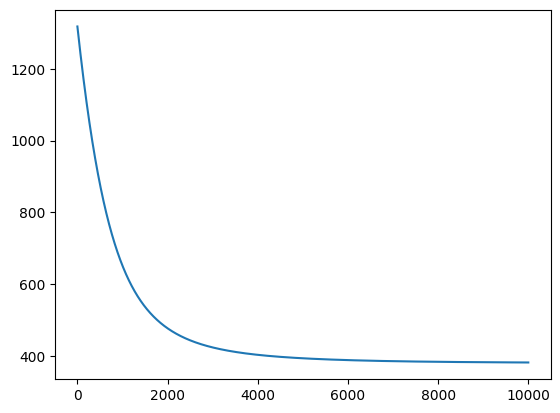

In [9]:
class MyLogisticRegression:
    def __init__(self, x, y, nfeats):
        self.x = x
        self.y = y.reshape(-1,1)
        self.beta = np.random.rand(1,nfeats)
    
    def _gradient(self, x, y, ypred):
        grads = (x.T @ (ypred - y)) / len(x)
        return grads.T
    
    def _sigmoid(self, z):
        return 1/(1 + np.exp(-z))
    
    def _z(self, beta, x):
        return x @ beta.T

    def _nll(self, z, y):
        'negative log loss'
        return (
            - y.T @ np.log(sigmoid(z)) - 
            ((1 - y).T @ np.log(1 - sigmoid(z)))
        )

    def fit(self, lr=0.001):
        i=0
        logging_betas = []
        logging_loss = []
        while True:
            logging_betas.append(self.beta)
            logging_loss.append(self._nll(self._z(self.beta, self.x), self.y)[0])

            if i >= 10000:
                return self.beta, logging_loss
            
            _ypred = self._sigmoid(self._z(self.beta, self.x))
            _gradient = self._gradient(self.x, self.y, _ypred)
            self.beta = self.beta - ((lr * _gradient))

            i += 1
    
my_lr = MyLogisticRegression(x, y, nfeats)
_betas, _losses = my_lr.fit()
print(_betas)
plt.plot(_losses)

In [10]:
my_pred_proba = x @ my_lr.beta.T
my_pred = np.where(my_pred_proba > 0.5, 1, 0)
my_count_errors = np.sum(np.abs(my_pred - y.reshape(-1,1)))
my_count_errors / len(x)

np.float64(0.17)

In [11]:
skl_pred_proba = lr.predict_proba(x)[:,1]
skl_pred = np.where(skl_pred_proba > 0.5, 1, 0).reshape(-1,1)
skl_count_errors = np.sum(np.abs(skl_pred - y.reshape(-1,1)))
skl_count_errors/len(x)

np.float64(0.157)

#### Newton-Raphson Method

- Newton Raphson (NR) follows the same logic as Gradient Descent (GD), so we won't repeat the full explanation. See section above on Gradient Descent

- We will start at the point where NR departs from GD

- Recall that, in gradient descent, we compute a Taylor expansion around the negative logloss (NLL) value of the parameter set $\hat{\beta}$

$$\begin{aligned}
    \text{NLL}(\beta + \Delta \beta) &= \text{NLL}(\beta) + \nabla_{\beta} \text{NLL}(\beta) \cdot \Delta\beta + \frac{1}{2} \cdot (\Delta \beta)^T \cdot \nabla_{\beta}^{2} \text{NLL}(\beta) \cdot (\Delta \beta) \\ \\
    \text{where} \\
    &\qquad \nabla_{\beta}^{n} \text{NLL}(\beta) \qquad \text{ n-th derivative of NLL w.r.t } \beta
\end{aligned}$$

- In GD, we ignored the second derivative of the Taylor expansion because we assumed it would be too small to affect our convergence. In NR, however, we don't make this assumption

- For simplicity, let's use $J(\beta)$ to represent the Jacobian, and $H(\beta)$ to represent the Hessian. This gives us

$$\begin{aligned}
    \text{NLL}(\beta + \Delta \beta) &= \text{NLL}(\beta) + J(\beta) \cdot \Delta\beta + \frac{1}{2} \cdot (\Delta \beta)^T \cdot H(\beta) \cdot (\Delta \beta)
\end{aligned}$$

- To get the minimum of this function, we differentiate $\text{NLL}$ w.r.t $\Delta \beta$ and set to 0, after which, we solve for $\Delta \beta$

$$\begin{aligned}
    \frac{\partial}{\partial \Delta \beta} (\text{NLL}(\beta + \Delta \beta)) &= \frac{\partial}{\partial \Delta \beta} (\text{NLL}(\beta) + J(\beta) \cdot \Delta\beta + \frac{1}{2} \cdot (\Delta \beta)^T \cdot H(\beta) \cdot (\Delta \beta)) \\
    &= J(\beta) + H(\beta) \cdot \Delta \beta \\
    &= 0 \\ \\

    \therefore \Delta \beta &= -H^{-1}(\beta) \cdot J(\beta)
\end{aligned}$$

- This tells us that the update should be
$$\begin{aligned}
    \beta &= \beta - \alpha \cdot H^{-1}(\beta) \cdot J(\beta)
\end{aligned}$$

##### Computing the Hessian

- We previously computed the Jacobian $$\frac{\partial \text{NLL}}{\partial \beta} = X^T (\hat{y} - y_i)$$ 

- Now, we want the Hessian 
    $$\begin{aligned}
        \frac{\partial^2\text{NLL}}{\partial \beta^2} &= \frac{\partial}{\partial \beta} (X^T (\hat{y} - y_i)) \\
        &= X^T \frac{\partial \hat{y}}{\partial \beta}
    \end{aligned}$$ 

- Deriving $\frac{\partial \hat{y}}{\partial \beta}$
    $$\begin{aligned}
        \frac{\partial \hat{y}}{\partial \beta} &= \frac{\partial}{\partial \beta} (\sigma(X\beta^T)) \\
        &= \frac{\partial \hat{y}}{\partial \sigma} \cdot \frac{\partial \sigma}{\partial z} \cdot \frac{\partial z}{\partial \beta} \\
        &= \hat{y} \cdot (1 - \hat{y}) \cdot X & \qquad \frac{\partial \sigma}{\partial z} = \hat{y} \cdot (1 - \hat{y}) \quad \text{ See derivation in gradient descent}
    \end{aligned}$$ 

- Therefore
    $$\begin{aligned}
       \frac{\partial^2\text{NLL}}{\partial \beta^2} &= X^T \frac{\partial \hat{y}}{\partial \beta} \\
        &= X^T \cdot \hat{y} \cdot (1 - \hat{y}) \cdot X
    \end{aligned}$$ 

- Since $\hat{y} \cdot (1 - \hat{y})$ is actually an element-wise scalar product, we need to convert it to matrix form to multiply it with $X$

- To do this, there is a neat trick; we simply diagonalise $\hat{y} \cdot (1 - \hat{y})$
    - Why does this work?
    - Image we have a matrix $A = \begin{bmatrix} 1 & 2 \end{bmatrix}$
    - We diagonalise $A$ such that $A' = \begin{bmatrix} 1 & 0 \\ 0 & 2 \end{bmatrix}$
    - Let's define another matrix $\begin{bmatrix} 3 & 4 \\ 5 & 6 \end{bmatrix}$
    - Then $A' \cdot B = \begin{bmatrix} 1 & 0 \\ 0 & 2 \end{bmatrix} \cdot \begin{bmatrix} 3 & 4 \\ 5 & 6 \end{bmatrix} = \begin{bmatrix} 3 & 4 \\ 10 & 12 \end{bmatrix}$
    - We have just taken the elements of $A$, and done a row-wise broadcast multiplication of $A$ into $B$!

- Finally, this gives us
    $$\begin{aligned}
       \frac{\partial^2\text{NLL}}{\partial \beta^2} &= X^T \cdot \text{diag}(\hat{y} \cdot (1 - \hat{y})) \cdot X \\
       &= X^T \cdot R \cdot X
    \end{aligned}$$ 


##### Implementation

In [12]:
nfeats = 10
x, y = make_classification(n_samples=1000, n_features=nfeats, n_informative=nfeats, n_redundant=0, n_classes=2, random_state=42)

In [13]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(x, y)
lr.coef_

array([[ 0.38442747, -0.81225793, -0.27842256,  0.49594458,  0.91747264,
         0.00808077,  0.35262925, -0.10525396, -0.23241649,  0.01113319]])

[[ 0.27335849 -0.77206388 -0.33488131  0.47038385  0.80628069 -0.01873412
   0.34797294 -0.13933052 -0.16712402  0.076229  ]]


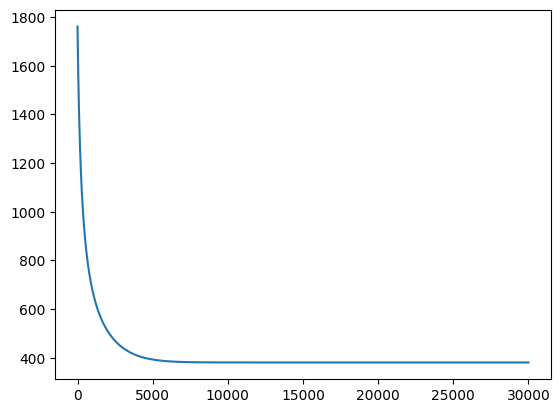

In [43]:
class MyLogisticRegression:
    def __init__(self, x, y, nfeats):
        self.x = x
        self.y = y.reshape(-1,1)
        self.beta = np.random.rand(1,nfeats)
    
    def _gradient(self, x, y, ypred):
        grads = (x.T @ (ypred - y)) / len(x)
        return grads.T
    
    def _hessian(self, x, ypred):
        R = np.diag((ypred * (1 - ypred)).reshape(-1,))
        hessian = x.T @ R @ x
        return hessian

    def _sigmoid(self, z):
        return 1/(1 + np.exp(-z))
        
    def _z(self, beta, x):
        return x @ beta.T

    def _nll(self, z, y):
        'negative log loss'
        return (
            - y.T @ np.log(sigmoid(z)) - 
            ((1 - y).T @ np.log(1 - sigmoid(z)))
        )

    def fit(self, lr=0.5):
        i=0
        logging_betas = []
        logging_loss = []
        while True:
            logging_betas.append(self.beta)
            logging_loss.append(self._nll(self._z(self.beta, self.x), self.y)[0])

            if i >= 30_000:
                return self.beta, logging_loss
            
            _ypred = self._sigmoid(self._z(self.beta, self.x))
            _gradient = self._gradient(self.x, self.y, _ypred)
            _hess = self._hessian(self.x, _ypred)
            _inv_hess = np.linalg.inv(_hess)
            self.beta = self.beta - (lr * (_inv_hess @ _gradient.T).reshape(1,-1))

            i += 1
            
my_lr = MyLogisticRegression(x, y, nfeats)
_betas, _losses = my_lr.fit()
print(_betas)
plt.plot(_losses)

In [45]:
my_pred_proba = x @ my_lr.beta.T
my_pred = np.where(my_pred_proba > 0.5, 1, 0)
my_count_errors = np.sum(np.abs(my_pred - y.reshape(-1,1)))
my_count_errors / len(x)

np.float64(0.169)

In [46]:
skl_pred_proba = lr.predict_proba(x)[:,1]
skl_pred = np.where(skl_pred_proba > 0.5, 1, 0).reshape(-1,1)
skl_count_errors = np.sum(np.abs(skl_pred - y.reshape(-1,1)))
skl_count_errors/len(x)

np.float64(0.157)

#### Iteratively Reweighted Least Squares (IRLS)

- As it turns out, IRLS is literally the same thing as Newton-Raphson, with some creative re-interpretation of the update formula

- In NR, recall that

$$\begin{aligned}
    \beta &= \beta - \alpha \cdot H(\beta)^{-1} \cdot J(\beta) \\ \\
    &\text{where} \\
    &\quad H(\beta) = X^T R X \quad \text{ is the Hessian} \\
    &\quad J(\beta) = X^T (\hat{y} - y) \quad \text{ is the Jacobian}
\end{aligned}$$

- Rewriting the update formula

$$\begin{aligned}
    \beta &= \beta - (X^T R X)^{-1} X^T(\hat{y} - y)
\end{aligned}$$

- This happens to be exactly the update procedure for weighted least squares, where $R$ replaces $W$, which is the matrix of weights!